Traing process and results of verifiable case 3.

The ground truth PDF:
$$
p(\theta_1,\theta_2)=\left[\frac{1}{2}\mathcal{N}(\theta_1|-6,2^2)+\frac{1}{2}\mathcal{N}(\theta_1|6,2^2)\right]\times\left[\frac{1}{2}\mathcal{N}(\theta_2|\frac{1}{4}\theta_1^2,1)+\frac{1}{2}\mathcal{N}(\theta_2|0,1)\right]
$$

In [1]:
import sys
sys.path.append('..')
from kmade.core import *
import torch
import os
import numpy as np
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [2]:
def generate_data(num_samples,seed=2024):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # Generate first component samples
    samples1 = torch.normal(-6, 2, (num_samples,))
    samples2 = torch.normal(6, 2, (num_samples,))
    
    # Generate random weights
    weights = torch.bernoulli(torch.full((num_samples,), 0.5))
    
    # Mixture for theta1
    theta1 = weights * samples1 + (1 - weights) * samples2
    
    # Generate second component samples
    samples1 = torch.normal(0.25*theta1**2, 1)
    samples2 = torch.normal(0, 1, (num_samples,))
    
    # Generate new weights for second mixture
    weights = torch.bernoulli(torch.full((num_samples,), 0.5))
    
    # Mixture for X2
    theta2 = weights * samples1 + (1 - weights) * samples2
    
    return torch.stack((theta1, theta2), dim=1).to(device)

train_data=generate_data(2000,seed=2024)
test_data=generate_data(2000,seed=2025)

dataset={'train_data':train_data,'test_data':test_data}

**KMADE**

In [3]:
model=MGKMADE(data_l=2,n_comps=2,hidden_layers=[],grid=5,k=3,seed=2024,input_order='sequential',mode='random',device=device,ckpt_path='checkpoints',ifperturb=True,bias_mean=0,bias_std=2);

checkpoint directory created: checkpoints
saving model version 0.0


In [4]:
model.fit(dataset=dataset,opt='LBFGS',steps=30,lamb=1e-3,lr=1,loss_fn=loss_function);
model.fit(dataset=dataset,opt='Adam',steps=1000,lamb=1e-3,lr=1e-2,loss_fn=loss_function);

| train_loss: 5.71e+00 | test_loss: 5.70e+00 | reg: 1.45e+00 | : 100%|█| 30/30 [00:07<00:00,  3.96it


saving model version 0.1


| train_loss: 4.84e+00 | test_loss: 4.86e+00 | reg: 7.92e-01 | : 100%|█| 1000/1000 [00:10<00:00, 96.

saving model version 0.2


In [5]:
os.makedirs('outputs', exist_ok=True)
model.saveckpt('outputs/experiment3')

In [6]:
model.auto_symbolic()

fixing (0,0,0) with 0
fixing (0,0,1) with x^2, r2=0.9999331207540437, c=2
fixing (0,0,2) with 0
fixing (0,0,3) with 0, r2=0.0, c=0
fixing (0,0,4) with 0
fixing (0,0,5) with 0, r2=0.0, c=0
fixing (0,0,6) with 0
fixing (0,0,7) with 0, r2=0.0, c=0
fixing (0,0,8) with 0
fixing (0,0,9) with 0, r2=0.0, c=0
fixing (0,0,10) with 0
fixing (0,0,11) with 0, r2=0.0, c=0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,1,2) with 0
fixing (0,1,3) with 0
fixing (0,1,4) with 0
fixing (0,1,5) with 0
fixing (0,1,6) with 0
fixing (0,1,7) with 0
fixing (0,1,8) with 0
fixing (0,1,9) with 0
fixing (0,1,10) with 0
fixing (0,1,11) with 0
saving model version 0.3


In [7]:
model.fit(dataset=dataset,opt='Adam',lr=1e-3,steps=200,loss_fn=loss_function);

| train_loss: 4.84e+00 | test_loss: 4.86e+00 | reg: 0.00e+00 | : 100%|█| 200/200 [00:05<00:00, 33.63

saving model version 0.4


In [8]:
#save the expression
save_expr(model,path='outputs/experiment3')

In [9]:
symbolic=True
if symbolic:
    sample_kmade=sampler(n_samples=40000,path='outputs/experiment3')
else:
    model=load_model('outputs/experiment3')
    sample_kmade=model.sample(n_samples=40000).detach().cpu().numpy()

sample_kmade=np.column_stack((sample_kmade[:,1],sample_kmade[:,0]))

In [10]:
#true
sample_true=generate_data(40000,seed=2024)
sample_true = torch.stack([sample_true[:, 1], sample_true[:, 0]], dim=1).detach().cpu().numpy()

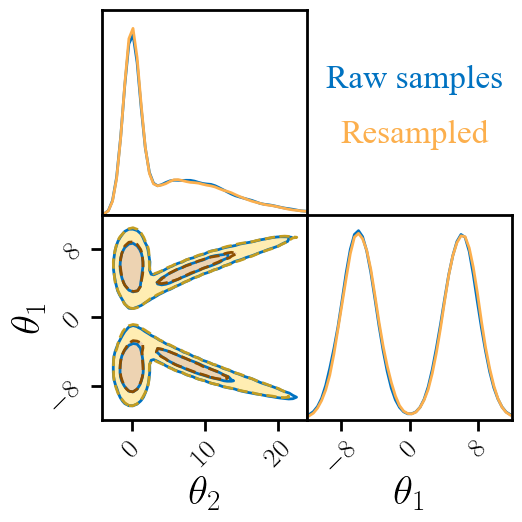

In [11]:
#configuration of corner plots
contour_kwargs={'colors1':['#0072c1'],
                'colors2':['#c39d21','#8d4e00'],
                'levels':[0.5,0.9],
                'width':[2,2],
                'linestyles':['-','--'],
                'smooth':1}
contourf_kwargs={'colors':['white','#ffedb2','#edd3b2']}
hist_kwargs={'color':['#0072c1','#fcaf4d'],
             'width':[2,2],
             'linestyles':['-','-'],
             'alpha':1,
             'bins':50,
             'smooth1d':1}
var_kwargs={'names':[r"$\theta_{2}$",r"$\theta_{1}$"],
            'ranges':[(-4,24),(-12,12)],
            'size':30,
            'pad':-0.03}
axes_kwargs_corner={'width':2,
             'length':8,
             'size':20,
             'color':'black',
             'rotationx':45,'rotationy':45,
             'max_n_ticks':3}

legend_kwargs_corner={'legend1':'Raw samples','legend2':'Resampled',
              'loc1':(0.75,0.8),'loc2':(0.75,0.7),
              'size':24,
              'family':'Times New Roman',
              'weights':['normal','normal'],
              'ha':'center','va':'center'}
corner_plot(sample_true,sample_kmade,
            path='outputs/experiment3_sym.pdf' if symbolic else 'outputs/experiment3_nn.pdf',
            contour_kwargs=contour_kwargs,contourf_kwargs=contourf_kwargs,hist_kwargs=hist_kwargs,
            var_kwargs=var_kwargs,axes_kwargs=axes_kwargs_corner,legend_kwargs=legend_kwargs_corner)

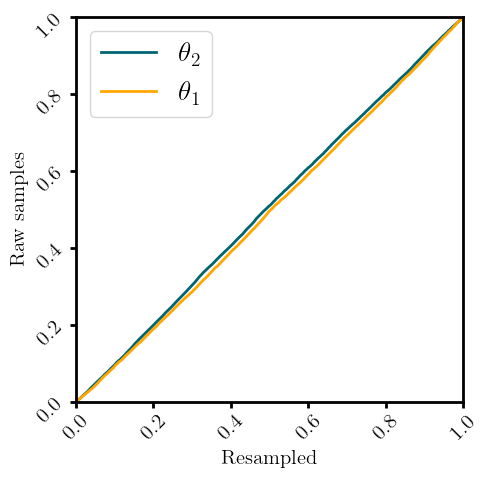

In [12]:
axes_kwargs_pp={'width':2,
             'size':15,
             'weight':'normal',
             'length':4,
             'color':'black',
             'rotationx':45,'rotationy':45}
legend_kwargs_pp={'loc':'best',
               'color':'black',
               'ls':[],
               'handlelength':2,
               'prop':{'size':20}}
title_kwargs_pp={'content':'',
              'size':12,
              'color':'black',
              'family':'Times New Roman',
              'weight':'bold',
              'pad':0.05,
              'if_title':False}
label_kwargs={'label1':'Resampled','label2':'Raw samples',
              'size':15,
              'family':'Times New Roman',
              'color1':'black','color2':'black',
              'weight1':'bold','weight2':'bold',
              'pad':0}
ref_kwargs={'color':'red',
            'alpha':1,
            'linestyle':'--',
            'width':2,
            'if_ref':False}
pp_plot(color_bar=['#006573','#FFA700'],
        column_names=[r"$\theta_{2}$",r"$\theta_{1}$"],
        sample_lw=2,
        path='outputs/experiment3_sympp.pdf' if symbolic else 'outputs/experiment3_nnpp.pdf',
        sample1=sample_true,sample2=sample_kmade,
        axes_kwargs=axes_kwargs_pp,
        legend_kwargs=legend_kwargs_pp,
        title_kwargs=title_kwargs_pp,
        label_kwargs=label_kwargs,
        ref_kwargs=ref_kwargs,)

**KDE**

Comparison with the KDE approach with the same storage space.

The file 'experiment3_data_kde.npy' contains 110 samples.

In [13]:
from sklearn.neighbors import KernelDensity
data=generate_data(110,seed=2024).detach().cpu().numpy()
kde = KernelDensity(kernel='gaussian', bandwidth=0.35).fit(data)
sample_kde=kde.sample(40000)
sample_kde=np.column_stack((sample_kde[:,1],sample_kde[:,0]))
np.save('experiment3_kde.npy', sample_kde)

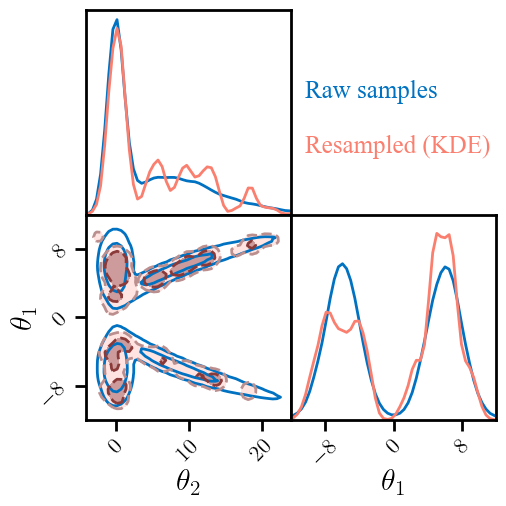

In [14]:
contour_kwargs={'colors1':['#0072c1'],
                'colors2':['#BC8F8F','#8B3A3A'],
                'levels':[0.5,0.9],
                'width':[2,2],
                'linestyles':['-','--'],
                'smooth':1}
contourf_kwargs={'colors':['white',"#FFE4E1",'#CD9B9B',]}
hist_kwargs={'color':['#0072c1','#fa7f6f'],
             'width':[2,2],
             'linestyles':['-','-'],
             'alpha':1,
             'bins':50,
             'smooth1d':1}
var_kwargs={'names':[r"$\theta_{2}$",r"$\theta_{1}$"],
            'ranges':[(-4,24),(-12,12)],
            'size':22,
            'pad':-0.06}
axes_kwargs_corner={'width':2,
             'length':8,
             'size':16,
             'color':'black',
             'rotationx':45,'rotationy':45,
             'max_n_ticks':3}

legend_kwargs_corner={'legend1':'Raw samples','legend2':'Resampled (KDE)',
              'loc1':(0.58,0.8),'loc2':(0.58,0.7),
              'size':18,
              'family':'Times New Roman',
              'weights':['normal','normal'],
              'ha':'left','va':'top'}
corner_plot(sample_true,sample_kde,
            path='outputs/kde_110.pdf',
            contour_kwargs=contour_kwargs,contourf_kwargs=contourf_kwargs,hist_kwargs=hist_kwargs,
            var_kwargs=var_kwargs,axes_kwargs=axes_kwargs_corner,legend_kwargs=legend_kwargs_corner)